# Quantum PR

The quantum-corrected Peng-Robinson model of Aasen *et al.* (https://doi.org/10.1063/1.5111364) can be used to account for quantum effects by empirical fits to the Feynman-Hibbs corrections.

The conventional Peng-Robinson approach is used, with an adjusted covolume $b_i$ given by

$$
b_i = b_{i, PR}\beta_i(T)
$$
with 
$$
\beta_i(T) = \left(\frac{1+A_i/(T+B_i)}{1+A_i/(T_{ci} + B_i)}\right)^3
$$
and Twu alpha functions are used to correct the attractive part.

In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas
import CoolProp.CoolProp as CP

import teqp
teqp.__version__

'0.19.1'

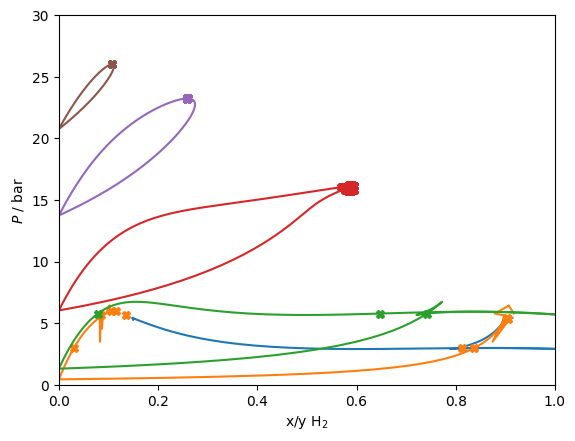

In [2]:
kij_library = {
    ('H2','Ne'): 0.18,
    ('He','H2'): 0.17
}
lij_library = {
    ('H2','Ne'): 0.0,
    ('He','H2'): -0.16
}

def get_model(names, c_factor=0):
    param_library = {
        'H2': {
            "Ls": [156.21],
            "Ms": [-0.0062072],
            "Ns": [5.047],
            "As": [3.0696],
            "Bs": [12.682],
            "cs / m^3/mol": [c_factor*-3.8139e-6],
            "Tcrit / K": [33.19],
            "pcrit / Pa": [12.964e5]
        },
        'Ne': {
            "Ls": [0.40453],
            "Ms": [0.95861],
            "Ns": [0.8396],
            "As": [0.4673],
            "Bs": [2.4634],
            "cs / m^3/mol": [c_factor*-2.4665e-6],
            "Tcrit / K": [44.492],
            "pcrit / Pa": [26.79e5]
        },
        'He': {
            "Ls": [0.48558],
            "Ms": [1.7173],
            "Ns": [0.30271],
            "As": [1.4912],
            "Bs": [3.2634],
            "cs / m^3/mol": [c_factor*-3.1791e-6],
            "Tcrit / K": [5.1953],
            "pcrit / Pa": [2.276e5]
        }
    }
    params = [param_library[name] for name in names]
    model = {k: [param[k][0] for param in params] for k in ['Ls','Ms','Ns','As','Bs','cs / m^3/mol','Tcrit / K','pcrit / Pa']}

    if len(names) == 1:
        model['kmat'] = [[0]]
        model['lmat'] = [[0]]
    else:
        kij = kij_library[names]
        model['kmat'] = [[0,kij],[kij,0]]
        lij = lij_library[names]
        model['lmat'] = [[0,lij],[lij,0]]
    
    j = {
        "kind": "QCPRAasen",
        "model": model
    }
    return teqp.make_model(j), j

model = get_model(('H2','Ne'))[0]
modelH2 = get_model(('H2',))[0]
modelNe = get_model(('Ne',))[0]

def get_traces(T, ipures):
    traces = []
    for ipure in ipures:
        rhovecL0 = np.array([0.0, 0.0])
        rhovecV0 = np.array([0.0, 0.0])
        if ipure == 1:            
            rhoL, rhoV = modelNe.superanc_rhoLV(T)
        else:
            rhoL, rhoV = modelH2.superanc_rhoLV(T)
        rhovecL0[ipure] = rhoL
        rhovecV0[ipure] = rhoV

        opt = teqp.TVLEOptions(); 
#         opt.polish=True; 
#         opt.integration_order=5; opt.rel_err=1e-10; 
#         opt.calc_criticality = True; 
        opt.crit_termination=1e-10
        trace = model.trace_VLE_isotherm_binary(T, rhovecL0, rhovecV0, opt)
        traces.append(trace)
    return traces

for T in [24.59, 28.0, 34.66, 39.57, 42.50]:
    if T < 26.0:
        traces = get_traces(T, [0, 1])
    else:
        traces = get_traces(T, [1])

    for trace in traces:
        df = pandas.DataFrame(trace)
        
        # Plot the VLE solution
        line, = plt.plot(df['xL_0 / mole frac.'], df['pL / Pa']/1e5)
        plt.plot(df['xV_0 / mole frac.'], df['pL / Pa']/1e5, color=line.get_color())

    # Plot the VLLE solution if found
    for soln in model.find_VLLE_T_binary(traces):
        for rhovec in soln['polished']:
            rhovec = np.array(rhovec)
            rhotot = sum(rhovec)
            x = rhovec/rhotot
            p = rhotot*model.get_R(x)*T*(1+model.get_Ar01(T, rhotot, x))
            plt.plot(x[0], p/1e5, 'X', color=line.get_color())
            # print(T, rhovec, x[0], p/1e5, 'bar')

plt.gca().set(xlabel='x/y H$_2$', ylabel='$P$ / bar', xlim=(0,1), ylim=(0,30));